In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

# for parsing collection dates
from dateutil.parser import parse, ParserError
import pytz

import subprocess
import gzip


In [2]:
# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [44]:
use_small_data = False
if use_small_data:
    phagesdf = pd.read_csv("../small_data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    phagesdf = pd.read_csv("../data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
githash = subprocess.check_output(["git", "describe", "--always"]).strip().decode()
print(f"Please note that this was run with git commit {githash} that has {phagesdf.shape[0]:,} genomes parsed and {phagesdf['Total Predicted Prophages'].sum():,} total prophages")

Please note that this was run with git commit d5ab3fd that has 553,082 genomes parsed and 20,946,107 total prophages


In [45]:
if use_small_data:
    checkv = pd.read_csv("../small_data/checkv.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    checkv = pd.read_csv("../data/checkv.tsv.gz", compression='gzip', header=0, delimiter="\t")
checkv = checkv.rename(columns={"BASE": "Contig"})
checkv

,Contig,contig_id,contig_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666849.1_PP1,20352,30,0,2,Not-determined,Genome-fragment,NaN
1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666854.1_PP2,28564,28,1,14,Low-quality,Genome-fragment,35.35
2,GCA_000003645.1_ASM364v1_genomic.gbff.gz,CM000714.1_PP1,40297,55,14,9,Medium-quality,Genome-fragment,53.01
3,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP1,21020,21,0,21,Not-determined,Genome-fragment,NaN
4,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP2,17449,20,1,12,Low-quality,Genome-fragment,9.46
...,...,...,...,...,...,...,...,...,...
361120,GCA_013142385.1_PDT000743393.1_genomic.gbff.gz,AATTQN010000003.1_PP1,38763,54,17,2,High-quality,High-quality,94.87
361121,GCA_013142465.1_PDT000743390.1_genomic.gbff.gz,AATTQP010000004.1_PP1,16755,24,0,2,Not-determined,Genome-fragment,NaN
361122,GCA_013142485.1_PDT000743385.1_genomic.gbff.gz,AATTQO010000003.1_PP1,16221,19,0,5,Low-quality,Genome-fragment,29.66
361123,GCA_013142505.1_PDT000743382.1_genomic.gbff.gz,AATTQW010000003.1_PP1,29193,38,6,0,Medium-quality,Genome-fragment,78.82


### Convert the checkv_quality into counts per genome so we can correlate it with other metrics

In [46]:
counts = {}
for index, rows in checkv.iterrows():
    if rows['Contig'] not in counts:
        counts[rows['Contig']] = {}
    counts[rows['Contig']][rows['checkv_quality']] = counts[rows['Contig']].get(rows['checkv_quality'], 0) + 1
countdf = pd.DataFrame.from_dict(counts).T
countdf = countdf.reset_index().rename(columns={"index" : "Contig"})
countdf

,Contig,Not-determined,Low-quality,Medium-quality,High-quality,Complete
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,1.0,1.0,NaN,NaN,NaN
1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,NaN,NaN,1.0,NaN,NaN
2,GCA_000003925.1_ASM392v1_genomic.gbff.gz,2.0,2.0,1.0,1.0,NaN
3,GCA_000003955.1_ASM395v1_genomic.gbff.gz,NaN,2.0,3.0,1.0,NaN
4,GCA_000005825.2_ASM582v2_genomic.gbff.gz,2.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...
72104,GCA_013142385.1_PDT000743393.1_genomic.gbff.gz,NaN,NaN,NaN,1.0,NaN
72105,GCA_013142465.1_PDT000743390.1_genomic.gbff.gz,1.0,NaN,NaN,NaN,NaN
72106,GCA_013142485.1_PDT000743385.1_genomic.gbff.gz,NaN,1.0,NaN,NaN,NaN
72107,GCA_013142505.1_PDT000743382.1_genomic.gbff.gz,NaN,NaN,1.0,NaN,NaN


In [47]:
phagesdf

,Contig,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,114,10,16,2,1,13,48916
1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,1,31,1,10,20,40297
2,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,1,38,6,13,19,268081
3,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,1,46,6,11,29,166286
4,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,3,33,3,9,21,93416
...,...,...,...,...,...,...,...,...,...
553077,GCA_902860175.1_LMG_5997_genomic.gbff.gz,7197255,38,21,33,2,14,17,69051
553078,GCA_902860185.1_LMG_6103_genomic.gbff.gz,6497464,13,8,22,0,10,12,0
553079,GCA_902860195.1_LMG_7053_genomic.gbff.gz,6702936,200,148,33,1,11,21,12819
553080,GCA_902860205.1_LMG_6001_genomic.gbff.gz,6320373,36,19,35,2,21,12,41572


In [48]:
phagecv = pd.merge(phagesdf, countdf, left_on='Contig', right_on='Contig', how='inner')
phagecv

,Contig,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,Not-determined,Low-quality,Medium-quality,High-quality,Complete
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,114,10,16,2,1,13,48916,1.0,1.0,NaN,NaN,NaN
1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,1,31,1,10,20,40297,NaN,NaN,1.0,NaN,NaN
2,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,1,38,6,13,19,268081,2.0,2.0,1.0,1.0,NaN
3,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,1,46,6,11,29,166286,NaN,2.0,3.0,1.0,NaN
4,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,3,33,3,9,21,93416,2.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72104,GCA_900699155.1_44927_B02-4_genomic.gbff.gz,3495680,2,2,27,3,1,23,106929,NaN,1.0,1.0,1.0,NaN
72105,GCA_900699165.1_39282_E01-4_genomic.gbff.gz,5102517,1,1,28,8,3,17,264470,2.0,2.0,2.0,1.0,1.0
72106,GCA_901538265.1_ASM90153826v1_genomic.gbff.gz,10135216,1,1,73,15,6,52,450509,4.0,4.0,7.0,NaN,NaN
72107,GCA_901538355.1_ASM90153835v1_genomic.gbff.gz,6690754,1,1,27,8,4,15,216478,3.0,2.0,3.0,NaN,NaN


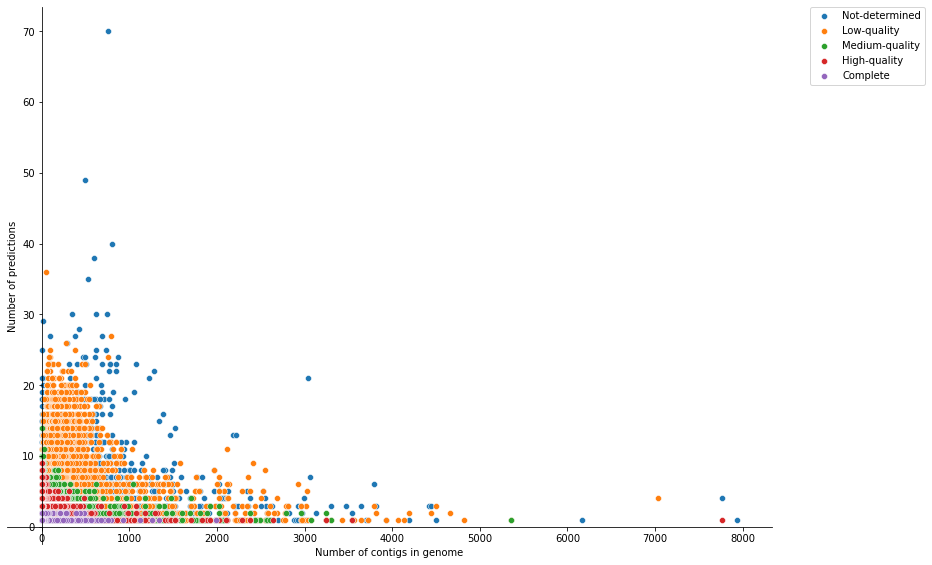

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]
for c in cols:
    ax = sns.scatterplot(x='Contigs', y=c, data=phagecv, label=c, ax=ax)

ax.set_ylabel('Number of predictions')
ax.set_xlabel('Number of contigs in genome')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

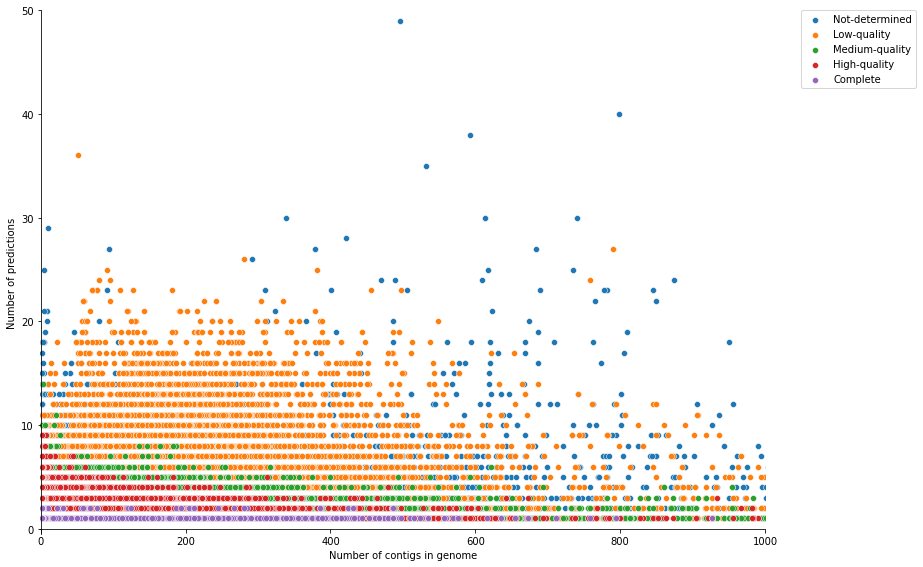

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
cols = ['Not-determined', "Low-quality", "Medium-quality", "High-quality", "Complete"]
for c in cols:
    ax = sns.scatterplot(x='Contigs', y=c, data=phagecv, label=c, ax=ax)

ax.set_xlim(-0.5, 1000)
ax.set_ylim(-0.5, 50)
ax.set_ylabel('Number of predictions')
ax.set_xlabel('Number of contigs in genome')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)